In [1]:
# -*- coding: utf-8 -*- Line 2
#----------------------------------------------------------------------------
# Project     : Price Alarm System Enhancement - Alarm2
# Created By  : Eungi Cho
# Created Date: 03/06/22
# Updated Date: 17/06/22
# version ='1.0'
# ---------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()
plt.style.use('default')

In [2]:
import pathlib
print(pathlib.Path().absolute())
df_raw = pd.read_csv('/Users/cho-eungi/Practice/CSV/market_entry_price.csv')
print(df_raw.shape)
df_raw = df_raw.drop_duplicates()
df_raw.head()

/Users/cho-eungi/Practice/Tridge
(10619563, 11)


,source_id,country,market_id,product_id,entry_id,currency,final_unit,date,price_min,price_max,price_avg
0,201,South Africa,1487,131,92926374,ZAR,kg,2020-07-20,19.64,21.2,19.956
1,39,India,810,490,41039702,INR,kg,2020-07-06,11.80,12.5,12.200
2,41,India,2188,133,50157058,INR,kg,2020-07-06,50.00,52.7,51.400
3,556,Bangladesh,6581,545,84458922,BDT,kg,2020-07-13,4400.00,4800.0,4600.000
4,150,Turkey,2482,126,58387432,TRY,NaN,2020-07-13,10.00,15.0,11.288


# Data Pre-processsing
Step1: Randomly sampling 100 entries to create 'entry_df'

Step2: Join 'time_df' to each 'entry_df', and make 'df' to reflect the actual frequency of price acquisition

In [3]:
# Create Test df
entry_lst = np.sort(df_raw['entry_id'].unique())
np.random.seed(0)
sample_entry = np.random.choice(entry_lst, 10000)
test_df = df_raw.loc[df_raw['entry_id'].isin(sample_entry)].sort_values(
    by = ['source_id', 'market_id', 'entry_id', 'date']).copy()
test_df['date'] = pd.to_datetime(test_df['date'])

In [4]:
# W-MON date range from 2020 to 2022
# Left Join Test DF and Time DF
empty_df = pd.DataFrame()
for entry in tqdm(sample_entry):
    entry_start = min(df_raw.loc[df_raw['entry_id'] == entry]['date'])
    date_range = pd.date_range(entry_start, '2022-05-31', freq = 'W-MON')
    time_df = pd.DataFrame({'date': date_range})
    
    time_df['entry_id_'] = entry
    entry_df = test_df.loc[test_df['entry_id'] == entry]
    joined_df = pd.merge(time_df, entry_df, left_on = ['date'], right_on = ['date'], how = 'left')
    empty_df = empty_df.append(joined_df)

empty_df = empty_df.drop(['entry_id'], axis = 1)
df = empty_df.copy()
df = df.sort_values(by = ['entry_id_', 'date'])
df.set_index(np.arange(len(df)), inplace=True)
len(df.entry_id_.unique())

100%|███████████████████████████████████████████| 10000/10000 [09:36<00:00, 17.34it/s]


9854

In [5]:
df.head()

,date,entry_id_,source_id,country,market_id,product_id,currency,final_unit,price_min,price_max,price_avg
0,2020-01-13,40857136,44.0,Belgium,2100.0,164.0,EUR,kg,324.03,324.03,324.030000
1,2020-01-20,40857136,44.0,Belgium,2100.0,164.0,EUR,kg,324.03,324.34,324.295714
2,2020-01-27,40857136,44.0,Belgium,2100.0,164.0,EUR,kg,324.34,324.34,324.340000
3,2020-02-03,40857136,44.0,Belgium,2100.0,164.0,EUR,kg,324.34,324.34,324.340000
4,2020-02-10,40857136,44.0,Belgium,2100.0,164.0,EUR,kg,322.03,324.34,322.690000


# Define Alarm Function

step1: Find mode of frequency by each entry

step2: Calculate threshold by each entry

In [6]:
# Initialize df_stats DataFrame
df_stats = df[['date', 'entry_id_', 'product_id', 'price_avg']]
df_ = df.copy()

In [7]:
# Count the occurances of consecutive null value
def count_consec_nan(array):
    consec_cnt = array.isnull().astype(int).groupby(array.notnull().astype(int).cumsum()).cumsum()
    return np.asarray(consec_cnt)

# Count Frequency of each entry
df_['consec_null'] = df_.groupby('entry_id_')['price_avg'].progress_transform(count_consec_nan)
df_['consec_null_shift'] = df_.groupby('entry_id_')['consec_null'].shift(1)

conditions  = [ (df_['consec_null'] == 0) & (df_['consec_null_shift'].isnull()),
               (df_['consec_null'] == 0) & (df_['consec_null_shift'].notnull())]
choices     = [ 0, df_['consec_null_shift'] + 1]
df_["freq"] = np.select(conditions, choices, default=np.nan)

# Calculate mode of frequency by entry 
entry_freq = df_.groupby('entry_id_')['freq'].agg(pd.Series.mode).to_dict()

100%|████████████████████████████████████████████| 9854/9854 [00:12<00:00, 778.32it/s]


In [8]:
reported_once_recently= []
reported_once_outdated = []
reported_regularly = []
reported_twice_recently = []
reported_twice_outdated = []
reported_unregularly_1 = []
reported_unregularly_2 = []

def calculate_threshold(df, threshold_dict):
    threshold_dict = {}
    for entry, freq in tqdm(entry_freq.items()):
        # 최빈값이 단일값만 존재할 경우:
        if isinstance(freq, float):
            if freq == 0:
                timedelt = round((pd.Timestamp(2022, 5, 31) - min(df.loc[df['entry_id_'] == entry]['date'])) / np.timedelta64(1, 'M'))
                if timedelt <= 2:
                    reported_once_recently.append(entry)
                    threshold_dict[entry] = np.inf
                else:
                    reported_once_outdated.append(entry)
                    threshold_dict[entry] = np.NINF
            else:
                reported_regularly.append(entry)
                if freq == 1:
                    threshold_dict[entry] = 4
                else:
                    threshold_dict[entry] = freq * 2
        # 최빈값이 복수일 경우:
        else:
            # 최빈값이 [0, 1] 일 경우. 즉 최초 한 번과 바로 그 다음 주기에 price가 보고된 후 한 번도 들어오지 않은 경우
            if (len(freq) == 2) & (np.min(freq) == 0) & (freq[np.where(freq == np.min(freq))[0][0] + 1] == 1):
                timedelt = round((pd.Timestamp(2022, 5, 31) - min(df.loc[df['entry_id_'] == entry]['date'])) / np.timedelta64(1, 'M'))
                if timedelt <= 2:
                    reported_twice_recently.append(entry)
                    threshold_dict[entry] = np.inf
                else:
                    reported_twice_outdated.append(entry)
                    threshold_dict[entry] = np.NINF

            # 최빈값이 [0,1,3,10,...] 등 최초 한 번 보고된 후에도 매우 불규칙적으로 보고되고 있는 entry일 경우
            else:
                value = freq[np.where(freq == np.min(freq))[0][0] + 1]
                if value == 1:
                    reported_unregularly_1.append(entry)
                    value = freq[np.where(freq == np.min(freq))[0][0] + 2]
                    threshold_dict[entry] = value * 2
                else:
                    reported_unregularly_2.append(entry)
                    threshold_dict[entry] = value * 2
                    
    return threshold_dict

threshold_dict = calculate_threshold(df_, entry_freq)

100%|███████████████████████████████████████████| 9854/9854 [00:03<00:00, 3056.33it/s]


In [9]:
def find_threshold(row, threshold_dict):
    entry_id = row.unique()[0]
    threshold_col = [threshold_dict[entry_id]] * len(row)
    return np.asarray(threshold_col[0])

df_['threshold'] = df_.groupby('entry_id_')['entry_id_'].transform(lambda row: find_threshold(row, threshold_dict))

conditions  = [ (df_['consec_null'] == 0) & (df_['consec_null_shift'].isnull()),
                (df_['consec_null'] == 0) & (df_['consec_null_shift'].notnull()),
                (df_['consec_null'] != 0) ]

choices     = [ 0, 1, df_['consec_null']]
df_["freq_judge"] = np.select(conditions, choices)

df_['alarm'] = np.where(df_['freq_judge'] > df_['threshold'], 1, 0)

In [10]:
df_.head()

,date,entry_id_,source_id,country,market_id,product_id,currency,final_unit,price_min,price_max,price_avg,consec_null,consec_null_shift,freq,threshold,freq_judge,alarm
0,2020-01-13,40857136,44.0,Belgium,2100.0,164.0,EUR,kg,324.03,324.03,324.030000,0,NaN,0.0,4.0,0,0
1,2020-01-20,40857136,44.0,Belgium,2100.0,164.0,EUR,kg,324.03,324.34,324.295714,0,0.0,1.0,4.0,1,0
2,2020-01-27,40857136,44.0,Belgium,2100.0,164.0,EUR,kg,324.34,324.34,324.340000,0,0.0,1.0,4.0,1,0
3,2020-02-03,40857136,44.0,Belgium,2100.0,164.0,EUR,kg,324.34,324.34,324.340000,0,0.0,1.0,4.0,1,0
4,2020-02-10,40857136,44.0,Belgium,2100.0,164.0,EUR,kg,322.03,324.34,322.690000,0,0.0,1.0,4.0,1,0


# Result

In [11]:
print('Seperate Cases by:')

print('\n',
    f'Reported less than three times but the first reported date <= 2 month:               {len(reported_once_recently) + len(reported_twice_recently)}, rate: {(len(reported_once_recently) + len(reported_twice_recently)) * 100 / len(df.entry_id_.unique()):.2f}%\n',
    f'Reported less than three times and the first reported date > 2 month:                {len(reported_once_outdated) + len(reported_twice_outdated)}, rate: {(len(reported_once_outdated) + len(reported_twice_outdated)) * 100 / len(df.entry_id_.unique()):.2f}%\n',
    f'Reported regularly:                                                                  {len(reported_regularly)}, rate: {len(reported_regularly) * 100 / len(df.entry_id_.unique()):.2f}%\n',
    f'Reported unregularly:                                                                {len(reported_unregularly_1) + len(reported_unregularly_2)}, rate: {(len(reported_unregularly_1)+(len(reported_unregularly_2))) * 100 / len(df.entry_id_.unique()):.2f}%\n',
)

Seperate Cases by:

 Reported less than three times but the first reported date <= 2 month:               205, rate: 2.08%
 Reported less than three times and the first reported date > 2 month:                1837, rate: 18.64%
 Reported regularly:                                                                  6775, rate: 68.75%
 Reported unregularly:                                                                1037, rate: 10.52%



In [12]:
alarm2_lst = df_[df_['alarm'] == 1]['entry_id_'].unique()
print(f'# of entries corresponding to alarm 2: {len(alarm2_lst)} / {len(df_.entry_id_.unique())},    Rate: {len(alarm2_lst)*100 / len(df_.entry_id_.unique()):.0f}%')

# of entries corresponding to alarm 2: 8343 / 9854,    Rate: 85%


In [13]:
cases = [reported_once_recently, reported_once_outdated, reported_regularly, reported_twice_recently, reported_twice_outdated, reported_unregularly_1, reported_unregularly_2]
error_cnt = []
for case in cases:
    error = len([entry for entry in case if entry in alarm2_lst])
    error_cnt.append(error)

print('Count number of entries that correspond to the alarm2 divided by cases:',        'error_cnt, total')

print('\n',
    f'Reported less than 3 times but the first reported date <= 2 month:                  {error_cnt[0] + error_cnt[3]}, {len(reported_once_recently) + len(reported_twice_recently)}\n',
    f'Reported less than 3 times and the first reported date > 2 month:                   {error_cnt[1] + error_cnt[4]}, {len(reported_once_outdated) + len(reported_twice_outdated)}\n',
    f'Reported regularly:                                                                 {error_cnt[2]}, {len(reported_regularly)}\n',
    f'Reported unregularly:                                                               {error_cnt[5] + error_cnt[6]}, {len(reported_unregularly_1) + len(reported_unregularly_2)}\n'
)

Count number of entries that correspond to the alarm2 divided by cases: error_cnt, total

 Reported less than 3 times but the first reported date <= 2 month:                  0, 205
 Reported less than 3 times and the first reported date > 2 month:                   1837, 1837
 Reported regularly:                                                                 5734, 6775
 Reported unregularly:                                                               772, 1037



In [14]:
df_stats = pd.concat([df_stats, df_[['consec_null', 'threshold', 'freq_judge', 'alarm']]], axis = 1)
df_stats['as_is_alarm'] = np.where(df_['consec_null'] > 3, 1, 0)
df_stats.head()

,date,entry_id_,product_id,price_avg,consec_null,threshold,freq_judge,alarm,as_is_alarm
0,2020-01-13,40857136,164.0,324.030000,0,4.0,0,0,0
1,2020-01-20,40857136,164.0,324.295714,0,4.0,1,0,0
2,2020-01-27,40857136,164.0,324.340000,0,4.0,1,0,0
3,2020-02-03,40857136,164.0,324.340000,0,4.0,1,0,0
4,2020-02-10,40857136,164.0,322.690000,0,4.0,1,0,0


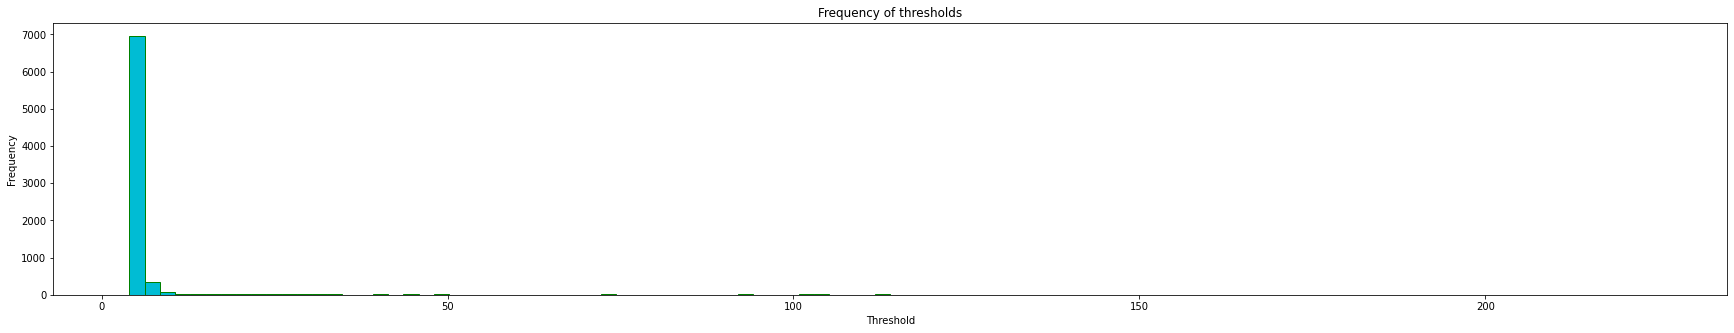

In [15]:
threshold_series = df_stats.groupby('entry_id_')['threshold'].nth(1)
threshold_series = threshold_series.astype(np.double)
mask = np.isfinite(threshold_series)
threshold_series = threshold_series[mask]

ax = threshold_series.plot.hist(
    figsize=(30, 5), bins = 100, title='Frequency of thresholds', 
    fontsize=10, color='#00bcd4', edgecolor='g', linestyle='-',
)
ax.set_xlabel('Threshold')
plt.style.use('default')
plt.show()

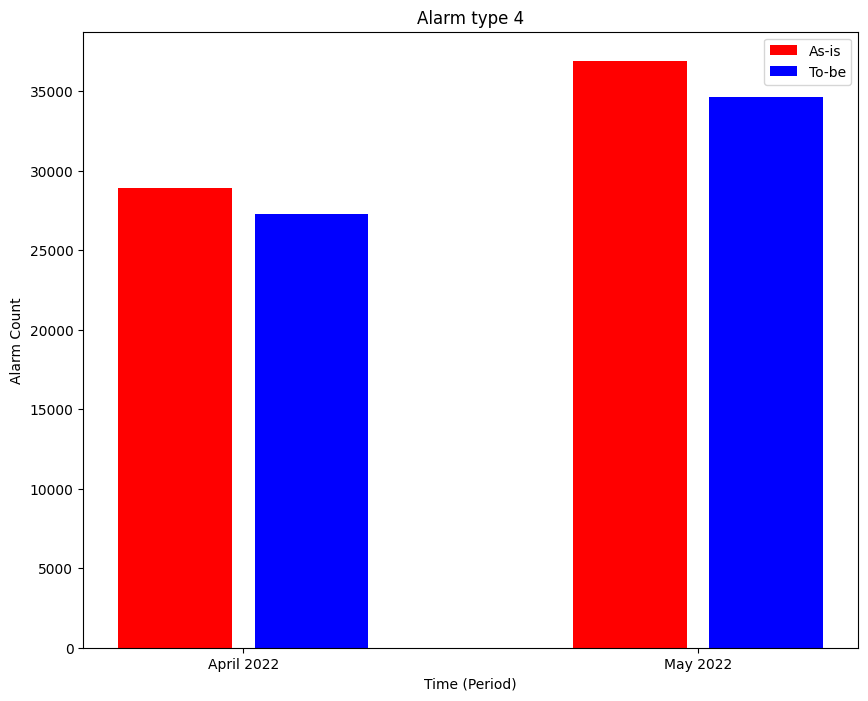

In [16]:
result_april_as_is = df_stats[(
    df_stats['date'] > pd.Timestamp('2022-04-01')) & (
    df_stats['date'] <= pd.Timestamp('2022-05-01')) & (
    df_stats['as_is_alarm']== 1)].groupby('entry_id_')['as_is_alarm'].sum()

result_april = df_stats[(
    df_stats['date'] > pd.Timestamp('2022-04-01')) & (
    df_stats['date'] <= pd.Timestamp('2022-05-01')) & (
    df_stats['alarm']== 1)].groupby('entry_id_')['alarm'].sum()

result_may_as_is = df_stats[(
    df_stats['date'] > pd.Timestamp('2022-05-01')) & (
    df_stats['date'] <= pd.Timestamp('2022-05-31')) & (
    df_stats['as_is_alarm']== 1)].groupby('entry_id_')['as_is_alarm'].sum()

result_may = df_stats[(
    df_stats['date'] > pd.Timestamp('2022-05-01')) & (
    df_stats['date'] <= pd.Timestamp('2022-05-31')) & (
    df_stats['alarm']== 1)].groupby('entry_id_')['alarm'].sum()

x = np.arange(2)
period = ['April 2022', 'May 2022']
asis = [result_april_as_is.sum(), result_may_as_is.sum()]
tobe = [result_april.sum(), result_may.sum()]

plt.figure(figsize = (10,8))
plt.bar(x, asis, color = 'red', width = 0.25, label = 'As-is')
plt.bar(x+0.3, tobe, color = 'blue', width = 0.25, label = 'To-be')
plt.xticks(x+0.15, period)
plt.legend()
plt.xlabel('Time (Period)')
plt.ylabel('Alarm Count')
plt.title('Alarm type 4')
plt.show()

# Plot Sample

In [17]:
df_stats_pivot = df_stats.pivot_table(['price_avg', 'alarm', 'as_is_alarm'], columns = ['date'], index = ['entry_id_'])

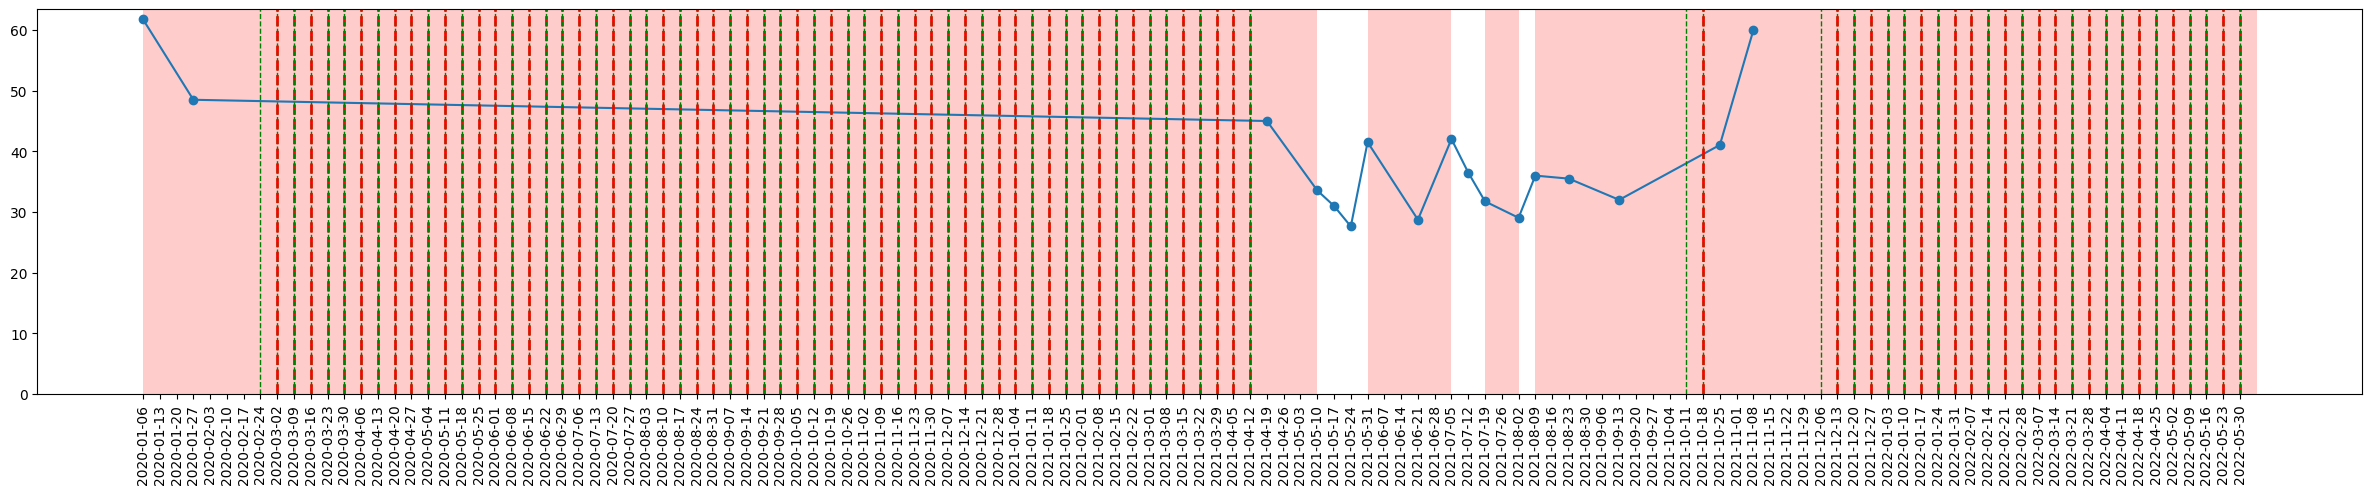

In [18]:
# Define function: Plot sample data with full time period
entry = 40867745
def plot_sample_with_ft(df_pivot, entry_id):
    # Masking null_value
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = sample_entry.date
    y = sample_entry.price_avg.astype(np.double)
    alarm2_x = sample_entry[sample_entry['alarm'] == 1].date
    as_is_alarm2_x = sample_entry[sample_entry['as_is_alarm'] == 1].date
    ymask = np.isfinite(y)
    
    plt.figure(figsize = (30, 5))
    plt.plot(x[ymask], y[ymask], linestyle = '-', marker = 'o')
    for i in range(len(alarm2_x)):
        plt.axvline(x=alarm2_x.iat[i], color='r', linestyle='--', linewidth=2, label = 'new_alarm')
    for i in range(len(as_is_alarm2_x)):
        plt.axvline(x=as_is_alarm2_x.iat[i], color='g', linestyle='--', linewidth=1, label = 'as_is_alarm')
    plt.xticks(sample_entry.date, rotation = 90)
    plt.ylim(bottom = 0)
    
    # axvspan with red color - find index of start & end point of null

    sample_entry = sample_entry.set_index('date')
    is_nan = sample_entry['price_avg'].isna()
    n_groups = is_nan.ne(is_nan.shift()).cumsum()
    
    if len(sample_entry[is_nan].groupby(n_groups).groups) > 1:
        gap_list = sample_entry[is_nan].groupby(n_groups).aggregate(
            lambda x: (
                x.index[0] + pd.DateOffset(days=-7),
                x.index[-1] + pd.DateOffset(days=+7)
            )
        )["price_avg"].values
    
        for gap in gap_list:
            plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)
        
    plt.style.use('default')
    plt.show()

plot_sample_with_ft(df_pivot = df_stats_pivot, entry_id = entry)